### aim: Notes for how to regrid with nco and cdo 

### date: 

In [35]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [36]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [37]:
import numpy as np
import cmocean as cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

## Steps for regridding (example from my work directory)

### change to where bashscripts are, start interactive session, add nco 


        cd /gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents

        int

        module purge

        module add nco/4.9.3
        
        module add cdo/2.0.5

### bashscript for extracting variable of interest with nco (ncrcat-tom.sh) 


        for i in {1950..2099}
        do
            echo ${i}
            ncrcat -v nav_lon,nav_lat,time_counter,deptht,mldr10_1 /gpfs/data/greenocean/software/runs/TOM12_TJ_1AA6/ORCA2_1m_${i}*1231_grid_T.nc /gpfs/data/greenocean/software/runs/TOM12_TJ_1AA6/ORCA2_${i}_mldr10_1.nc
            
### bashscript for regridding with cdo (regridTOM-mld.sh)

        tdir='//gpfs/data/greenocean/software/runs/TOM12_TJ_1BA6/'

        for i in {1950..2099}
        do

            echo "${i}"
            echo "!!!!!!"
            oldfil=${tdir}ORCA2_${i}_mldr10_1.nc
            newfil=${tdir}ORCA2_${i}_mldr10_1-rg.nc
            cdo remapbil,r360x180 ${oldfil} ${newfil}

### compare regridded data with original

cdo remapbil will automatically reproject any frield if it is given a nav_lon and a nav_lat

Text(0.5, 1.0, 'regridded file, mldr10_1, Jan 1950')

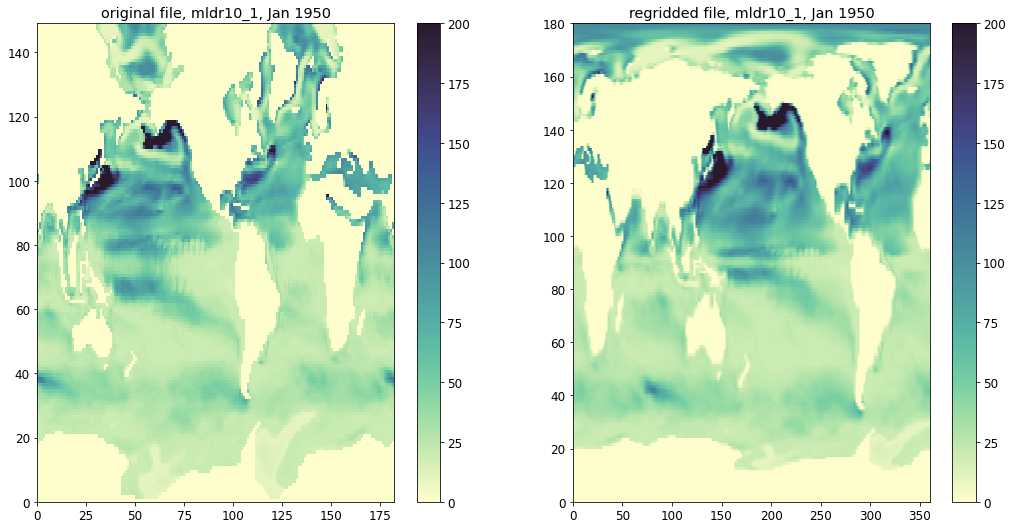

In [38]:
tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_1AA6/'
orig = xr.open_dataset(f'{tdir}ORCA2_1950_mldr10_1.nc')
regrid = xr.open_dataset(f'{tdir}ORCA2_1950_mldr10_1-rg.nc')



fact = 1.1
fig, axs = plt.subplots(1,2, figsize=(16*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

w = axs[0].pcolormesh(orig.mldr10_1[0,:,:], cmap = cm.cm.deep, vmin = 0, vmax = 200)
plt.colorbar(w, ax = axs[0])
w = axs[1].pcolormesh(regrid.mldr10_1[0,:,:], cmap = cm.cm.deep, vmin = 0, vmax = 200)
plt.colorbar(w, ax = axs[1])


axs[0].set_title('original file, mldr10_1, Jan 1950')
axs[1].set_title('regridded file, mldr10_1, Jan 1950')

### comparing mesh masks

Reprojecting the mesh mask won't work because our grid has a stripe pattern and the sizes of grid cells don't match those in real life (which are largest at the equator):


Text(0.5, 1.0, 'regridded file, tmask, Jan 1950')

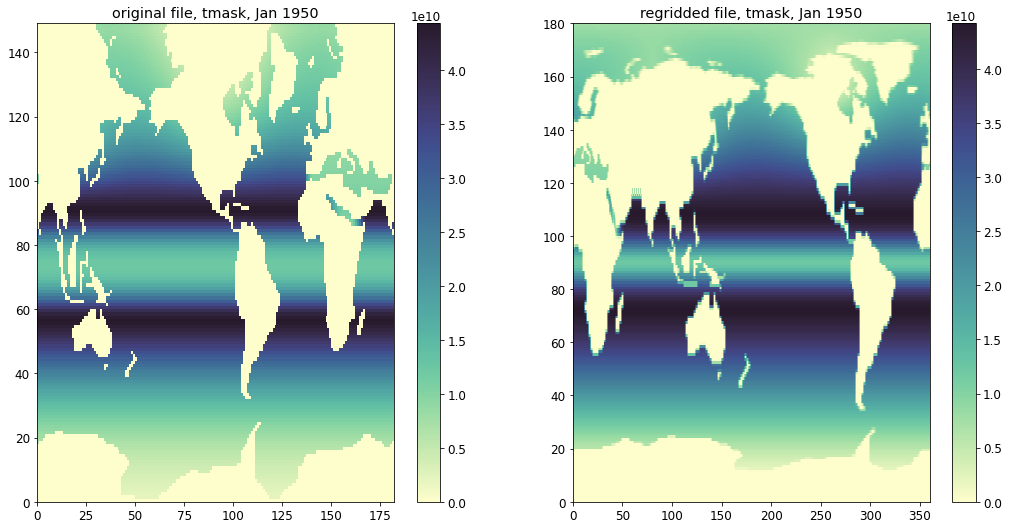

In [39]:
tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_1AA6/'
orig = xr.open_dataset(f'{tdir}ORCA2_1950_tmask.nc')
regrid = xr.open_dataset(f'{tdir}ORCA2_1950_tmask-rg.nc')



fact = 1.1
fig, axs = plt.subplots(1,2, figsize=(16*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

w = axs[0].pcolormesh(orig.tmask[0,:,:], cmap = cm.cm.deep)
plt.colorbar(w, ax = axs[0])
w = axs[1].pcolormesh(regrid.tmask[0,:,:], cmap = cm.cm.deep)
plt.colorbar(w, ax = axs[1])


axs[0].set_title('original file, tmask, Jan 1950')
axs[1].set_title('regridded file, tmask, Jan 1950')

## manual mesh mask

I made a custom mesh mask by calculating the size of each 1x1 degree grid manually (see `SOZONE/windAnalyis/wspdComponents/MannKendall-andMeansExtremes.ipynb`) and setting it to 0 where the reprojected mesh mask is 0. This naturally leads to some smaller problems in polynesia and New Zealand but is rougbly correct (checks of total land size etc). In general I would calculate quantities on a native grid, not a regridded one, if possible. 

Text(0.5, 1.0, 'regridded file, manually created mask')

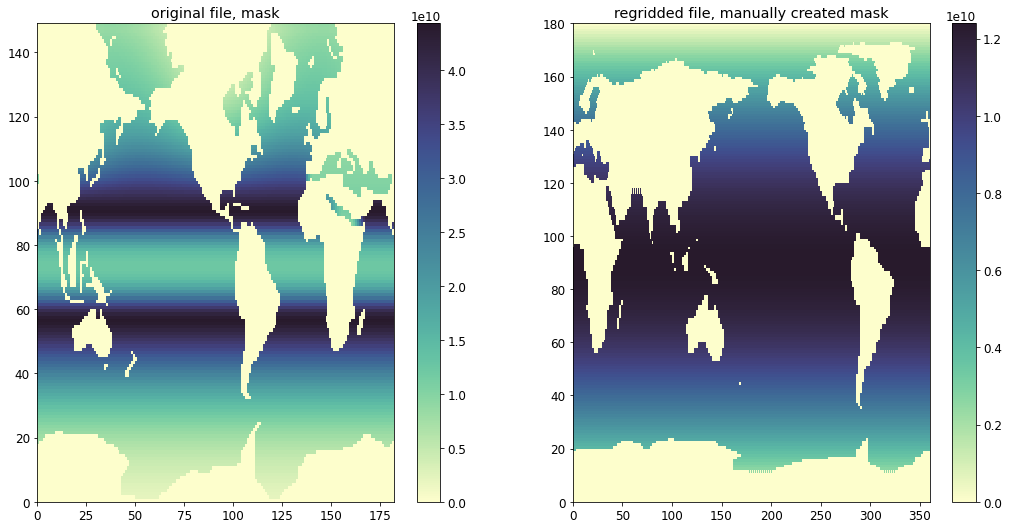

In [40]:
savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
cdomask = xr.open_dataset(savenam)
cdo_mask = cdomask.tmask

tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['tmask'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
tom_mask = tmesh.tmask

fact = 1.1
fig, axs = plt.subplots(1,2, figsize=(16*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

w = axs[0].pcolormesh(tom_mask, cmap = cm.cm.deep)
plt.colorbar(w, ax = axs[0])
w = axs[1].pcolormesh(cdo_mask, cmap = cm.cm.deep)
plt.colorbar(w, ax = axs[1])


axs[0].set_title('original file, mask')
axs[1].set_title('regridded file, manually created mask')

code to regrid the tmask, as a test

In [41]:
rg = False
if rg:
    tmesh.tmask

    tmask_broad = np.zeros([12,149,182])
    for i in range(0,12):
        tmask_broad[i,:,:] = tmesh.tmask.values


    tdir = '/gpfs/data/greenocean/software/runs/TOM12_TJ_1AA6/'
    w2 = xr.open_dataset(f'{tdir}ORCA2_1950_mldr10_1.nc')
    print('how dataset looks before modification')
    print(w2)

    tmesh

    ##add a new variable and modify it a bit, BAC from the above

    w2['tmask'] = xr.DataArray(tmask_broad, w2.mldr10_1.coords, w2.mldr10_1.dims, w2.mldr10_1.attrs)
    # w2.wspd.attrs = w2.Cflx.attrs

    w2.drop('mldr10_1')


    print('how dataset looks after adding dummy variable')
    print(w2)
    attrs = {'made_in':'SOZONE/windAnalyis/oceanFields/regrid_cdo_notes_test.ipynb',
    }
    w2.attrs = attrs

    w2.made_in
    #w2.to_netcdf('TOM12_1960_Cflx_AMEND3.nc')
    # plt.figure()
    # q = plt.pcolormesh(w2['Cflx'][0,:,:])
    # plt.colorbar(q)
    # plt.title('Cflx in test file')
    # plt.figure()
    # q = plt.pcolormesh(w2['BAC'][0,:,:])
    # plt.colorbar(q)
    # plt.title('BAC (dummy variable) in test file')

    w2.to_netcdf(f'{tdir}ORCA2_1950_tmask.nc')